<a href="https://colab.research.google.com/github/malloyca/steelpan-pitch/blob/main/onset-pitch/steelpan_onset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Steelpan Onset-based Pitch Detection

For 183rd Meeting of the Acoustical Society of America, December 8, 2022.

In [1]:
# imports

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import librosa
from librosa import display

print(f"TensorFlow version: {tf.__version__}")

physical_devices = tf.config.list_physical_devices()
print(physical_devices)

TensorFlow version: 2.9.2
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [6]:
# download the SASSE dataset # TODO: update dataset to newer version
!gdown 1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql
!unzip -qq '/content/SASSE_tiny_16.zip'

Downloading...
From: https://drive.google.com/uc?id=1hRfdF0ko2ItGK0y9z4xU_7VQLgRIx4Ql
To: /content/SASSE_tiny_16.zip
100% 40.9M/40.9M [00:00<00:00, 209MB/s]
replace SASSE_tiny_16/train/73_train_sample_58.wav? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


# Steelpan Note Transients

Let's begin by examining the attack transients of a few steelpan samples.

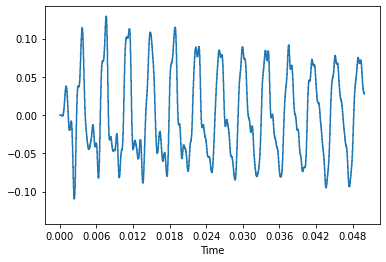

In [3]:
audio_01, sr = librosa.load('/content/SASSE_tiny_16/train/60_train_sample_101.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_01[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [4]:
frame_length = 2048
yin_out = librosa.yin(audio_01[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(yin_out)

[60.00674299 59.94693127 60.00902527 60.10209892 60.16317091]


In [5]:
frame_length = 2048
pyin_out, _, _ = librosa.pyin(audio_01[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 59.9 60.  60.1 60.2]


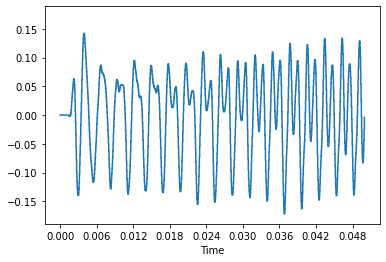

In [7]:
audio_02, sr = librosa.load('/content/SASSE_tiny_16/train/65_train_sample_5.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_02[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [8]:
frame_length = 2048
yin_out = librosa.yin(audio_02[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(yin_out)

[65.15781051 65.29300178 65.11050067 65.05926868 64.99918137]


In [9]:
frame_length = 2048
pyin_out, _, _ = librosa.pyin(audio_02[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[ nan 65.3 65.1 65.1 65. ]


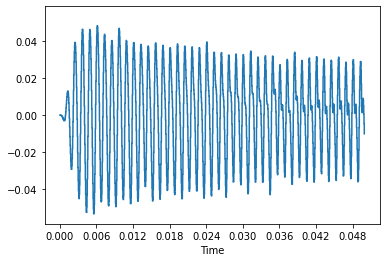

In [10]:
audio_03, sr = librosa.load('/content/SASSE_tiny_16/train/80_train_sample_142.wav')

#plot first 50 ms
fig, ax = plt.subplots()
librosa.display.waveshow(audio_03[:int(0.05*sr)], sr=sr, ax=ax)
plt.show()

In [11]:
frame_length = 2048
yin_out = librosa.yin(audio_03[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
yin_out = librosa.hz_to_midi(yin_out)
print(yin_out)

[80.0008385  79.98258798 79.99847746 80.03224232 80.0220681 ]


In [12]:
frame_length = 2048
pyin_out, _, _ = librosa.pyin(audio_03[:frame_length], fmin=librosa.note_to_hz('C2'), fmax=librosa.note_to_hz('C7'))
pyin_out = librosa.hz_to_midi(pyin_out)
print(pyin_out)

[nan 80. 80. 80. 80.]


# CRéPE-style network

## Model Builder

In [ ]:
models = {
    'tiny': None,
    'small': None,
    'medium': None,
    'large': None,
    'full': None
}

# the model is trained on 16 kHz audio for now # TODO: upgrade to a higher samplerate
model_samplerate = 1600

def make_model(model_capacity, metrics, weights=None):
  '''
  model_capacity: tiny, small, medium, large, full
  weights: path of .h5 weight file
  '''

  from tensorflow.keras.layers import Input, Reshape, Conv2D, BatchNormalization
  from tensorflow.keras.layers import MaxPool2D, Dropout, Permute, Flatten, Dense
  from tensorflow.keras.models import Model

  capacity_multiplier = {
      'tiny': 4, 'small': 8, 'medium': 16, 'large': 24, 'full': 32
  }(model_capacity)

  layers = [1, 2, 3, 4, 5, 6]
  filters = [n * capacity_multiplier for n in [32, 4, 4, 4, 8, 16]]
  widths = [512, 64, 64, 64, 64, 64]
  strides = [(4,1), (1,1), (1,1), (1,1), (1,1), (1,1)]

  x = Input(shape=(1024,), name='input', dtype='float32')
  y = Reshape(target_shape=(1024, 1, 1), name='input-reshape')(x)

  for l, f, w, s in zip(layers, filters, widths, strides):
    y = Conv2d(f, (w, 1), strides=s, padding='same',
               activation='relu', name="conv%d" % l)(y)
    y = BatchNormalization(name="conv%d-BN" % l)(y)
    y = MaxPool2D(pool_size=(2, 1), strides=None, padding='valid',
                  name="conv%d-maxpool" % l)(y)
    y = Dropout(0.25, name="conv%d-dropout" % l)(y)

  y = Permute((2, 1, 3), name="transpose")(y)
  y = Flatten(name="flatten")(y)
  y = Dense(360, activation='sigmoid', name="classifier")(y)

  model = Model(inputs=x, outputs=y)

  if weights != None:
    model.load_weights(weights)
  model.compile(tf.keras.optimizers.Adam(learning_rate=0.0002),
                'binary_crossentropy', metrics=metrics)
  
  models[model_capacity] = model

  return model

In [ ]:
# todo - Just use Librosa's db_to_power instead?
def db_to_pow(db):
  '''Convert from dB to power'''
  return 10**(db / 10)


def frame_energy(frame):
  '''Calculates the average energy for a frame
    
    Parameters
    ----------
    frame : np.array
      audio frame in np.float32 format

    Returns
    -------
    average_energy : float
      Average energy level for frame
  '''

  # Square the sample values to convert to energy values
  energy = frame**2

  # Sum the energy values to get total energy
  total_energy = np.sum(energy)

  # Divide by length to get average energy
  return total_energy / len(frame)

In [ ]:
make_model(_, _)